# Attribute Genration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from datetime import datetime
import numpy as np
from datetime import datetime
import seaborn as sns

In [2]:
def distance_between(lat1, lon1, lat2, lon2):
    """
    Haversine disance between two coordinates
    """
    R = 6371e3; #meters
    φ1 = np.deg2rad(lat1)
    φ2 = np.deg2rad(lat2)
    Δφ = np.deg2rad(lat2-lat1)
    Δλ = np.deg2rad(lon2-lon1)

    a = np.sin(Δφ/2)*np.sin(Δφ/2) + np.cos(φ1)*np.cos(φ2)*np.sin(Δλ/2)*np.sin(Δλ/2)
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))

    d = R * c
    return d

def plot_line(line):
    plt.figure(figsize=(10,5))
    plt.title('Line {0}'.format(line.line.iloc[0]))
    plt.plot(line.longitude, line.latitude,'-o')
    plt.show()

def plot_all_line(lines, line_id):
    unique_ids = lines[lines.line == line_id].id.unique()
    for _id in unique_ids:
        line = lines.query('id == {0} & line == {1}'.format(_id, str(line_id)))
        plot_line(line)
    
def plot_ids_line(line):
    line_ids = line.id.unique()
    plt.figure(figsize=(10,5))
    plt.title(line.line.iloc[0])
    different_ids = len(line_ids)
    colors = pl.cm.jet(np.linspace(0,1,different_ids))
    for size, id_ in enumerate(line_ids):
        l = line[line.id == id_]
        plt.plot(l.longitude, l.latitude, '-o', color=colors[size],markersize=(different_ids-size)*3)
    plt.show()
    
def plot_line_speed(line, show_speeds=True):
    plt.figure(figsize=(17,6))
    plt.title('line: '+str(line.line.iloc[0])+' id: '+str(line.id.iloc[0]))
    max_speed = 35
    min_speed = 0
    speeds = max_speed - min_speed 
    colors = pl.cm.jet(np.linspace(0, 1, speeds + 1))
    sps = []
    for step in line.itertuples():
        plt.plot(step.longitude, step.latitude, '-o', color=colors[int(step.speed)],markersize=step.speed)
        sps.append(str(int(ms_to_kh(step.speed)))+' k/h')
    if show_speeds:
        plt.legend(sps)
    plt.show()
    
def ms_to_kh(ms):
    return (ms*18)/5

In [3]:
data = pd.read_csv('../data/bus_data_stage_1.csv')
data = data.drop(['Unnamed: 0'], axis=1)
data.head()

,id,line,longitude,latitude,timestamp
0,76,217,-56.222400,-34.855885,2018-10-02 14:38:53
1,984,540,-56.201860,-34.909360,2018-10-02 14:39:08
2,288,7898,-56.175415,-34.901110,2018-10-02 14:39:08
3,1111,254,-56.136640,-34.872833,2018-10-02 14:39:08
4,22,540,-56.135277,-34.845554,2018-10-02 14:39:08


In [4]:
unique_lines = data.line.unique()

In [5]:
lines = pd.DataFrame()
for line in unique_lines:
    some_line  = data[data.line == line]
    unique_ids = some_line.id.unique() 
    for bus_id in unique_ids:
        line_by_id = some_line[some_line.id == bus_id]
        data_holder = pd.DataFrame(line_by_id)
        data_holder['next_longitude'] = line_by_id.longitude.shift(-1)
        data_holder['next_latitude']  = line_by_id.latitude.shift(-1)
        data_holder['next_timestamp'] = line_by_id.timestamp.shift(-1)
        data_holder['distance'] = np.zeros(len(data_holder))
        data_holder['distance'] = data_holder.apply(lambda x: distance_between(data_holder.latitude,
                                                                               data_holder.longitude,
                                                                               data_holder.next_latitude,
                                                                               data_holder.next_longitude))
        data_holder.drop(data_holder.index[-1], inplace=True)
        lines = lines.append(data_holder, ignore_index=True)

In [6]:
print('Missing Lines: '+str(len(lines.id.unique()) - len(data.id.unique())))

Missing Lines: -3


Podemos ver que tenemos 3 lineas faltantes en el archivo resultante, vamos a ver cuales son e investigar porque.

In [7]:
np.setdiff1d(data.id.unique(),lines.id.unique())

array([441, 928, 949])

In [8]:
data[data.id == 441]

,id,line,longitude,latitude,timestamp
82,441,372,-56.021667,-34.869667,2018-10-02 14:39:08


In [9]:
data[data.id == 928]

,id,line,longitude,latitude,timestamp
1468,928,372,-56.047527,-34.88614,2018-10-02 14:41:38


In [10]:
data[data.id == 949]

,id,line,longitude,latitude,timestamp
152,949,501,-56.135223,-34.806,2018-10-02 14:39:08


Podemos ver que las lineas faltantes no estan en el dataset resutante porque constan de un solo dato. Podemos considerarlas como outliers e ignorarlas.

In [11]:
line_times  = []
line_speeds = []

for row in lines.itertuples():
    start_time = datetime.strptime(row.timestamp,'%Y-%m-%d %H:%M:%S')
    end_time   = datetime.strptime(row.next_timestamp,'%Y-%m-%d %H:%M:%S')
    time = end_time - start_time
    speed = row.distance/time.total_seconds()
    line_times.append(time)
    line_speeds.append(speed)

lines['time']  = np.zeros(len(lines))
lines['time']  = line_times
lines['speed'] = np.zeros(len(lines))
lines['speed'] = line_speeds
del line_times
del line_speeds

In [12]:
lines.head()

,id,line,longitude,latitude,timestamp,next_longitude,next_latitude,next_timestamp,distance,time,speed
0,76,217,-56.222400,-34.855885,2018-10-02 14:38:53,-56.222717,-34.855766,2018-10-02 14:39:23,31.807877,00:00:30,1.060263
1,76,217,-56.222717,-34.855766,2018-10-02 14:39:23,-56.222733,-34.855780,2018-10-02 14:39:53,2.134200,00:00:30,0.071140
2,76,217,-56.222733,-34.855780,2018-10-02 14:39:53,-56.222916,-34.855682,2018-10-02 14:40:08,19.939152,00:00:15,1.329277
3,76,217,-56.222916,-34.855682,2018-10-02 14:40:08,-56.222866,-34.855682,2018-10-02 14:40:23,4.562295,00:00:15,0.304153
4,76,217,-56.222866,-34.855682,2018-10-02 14:40:23,-56.222850,-34.855667,2018-10-02 14:40:38,2.216614,00:00:15,0.147774


Ahora vamos a revisar los datos calculados

In [13]:
lines.speed.describe()

count    96028.000000
mean         4.455507
std          3.623244
min        -11.337526
25%          1.415347
50%          3.783430
75%          6.725155
max         33.804600
Name: speed, dtype: float64

In [14]:
lines.distance.describe()

count    96028.000000
mean       109.918037
std        557.747270
min          0.000000
25%         23.732101
50%         65.265739
75%        115.928844
max      22490.074027
Name: distance, dtype: float64

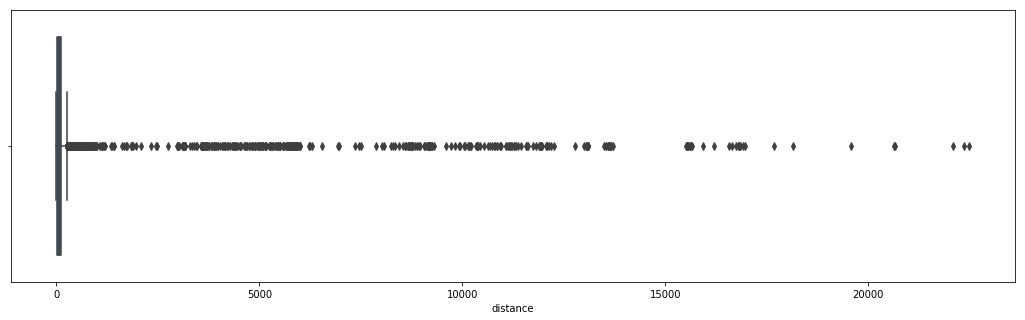

In [15]:
fig, ax = plt.subplots(figsize=(18,5))
ax = sns.boxplot(x=lines.distance)

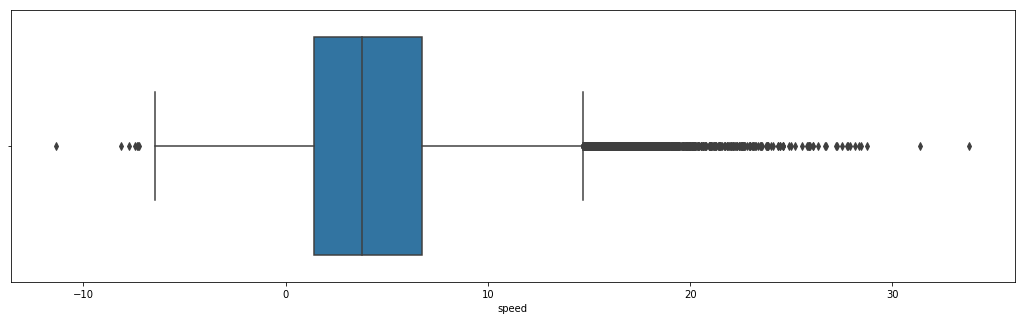

In [16]:
fig, ax = plt.subplots(figsize=(18,5))
ax = sns.boxplot(x=lines.speed)

Podemos ver que tenemos velocidades negativas y que un omnibus se movio 22.5km en un intervalo de tiempo.

In [17]:
negative_speeds = lines.query('speed < 0')
negative_speeds

,id,line,longitude,latitude,timestamp,next_longitude,next_latitude,next_timestamp,distance,time,speed
218,76,217,-56.217384,-34.858532,2018-10-02 17:14:12,-56.217384,-34.858517,2018-10-02 17:13:57,1.667924,-1 days +23:59:45,-0.111195
282,68,217,-56.189632,-34.872250,2018-10-02 14:50:38,-56.189167,-34.873150,2018-10-02 14:50:23,108.694973,-1 days +23:59:45,-7.246332
8311,288,7898,-56.195280,-34.905000,2018-10-02 14:49:38,-56.194637,-34.905000,2018-10-02 14:49:08,58.635926,-1 days +23:59:30,-1.954531
10079,1111,254,-56.142303,-34.850860,2018-10-02 14:49:08,-56.142750,-34.851334,2018-10-02 14:48:53,66.646249,-1 days +23:59:45,-4.443083
11549,26,254,-56.148193,-34.879470,2018-10-02 14:49:38,-56.148804,-34.879917,2018-10-02 14:48:53,74.678565,-1 days +23:59:15,-1.659524
16054,9,2391,-56.170444,-34.899776,2018-10-02 14:50:53,-56.169277,-34.899360,2018-10-02 14:50:38,116.045054,-1 days +23:59:45,-7.736337
16333,94,2391,-56.196835,-34.906140,2018-10-02 14:49:08,-56.195500,-34.906082,2018-10-02 14:48:53,121.909284,-1 days +23:59:45,-8.127286
17648,86,400,-56.167442,-34.898920,2018-10-02 14:49:08,-56.166805,-34.898083,2018-10-02 14:48:38,109.712778,-1 days +23:59:30,-3.657093
17655,86,400,-56.172554,-34.900723,2018-10-02 14:50:53,-56.171030,-34.900223,2018-10-02 14:50:08,149.690867,-1 days +23:59:15,-3.326464
17742,13,2390,-56.194942,-34.905945,2018-10-02 14:49:08,-56.196000,-34.906055,2018-10-02 14:48:53,97.251338,-1 days +23:59:45,-6.483423


Las distancias negativas parecen venir de problemas en los tiempos. Tiempos que parecen estar al revez, primero pasa por el destino y luego por el origen. Como son pocos datos vamos a descartarlos.

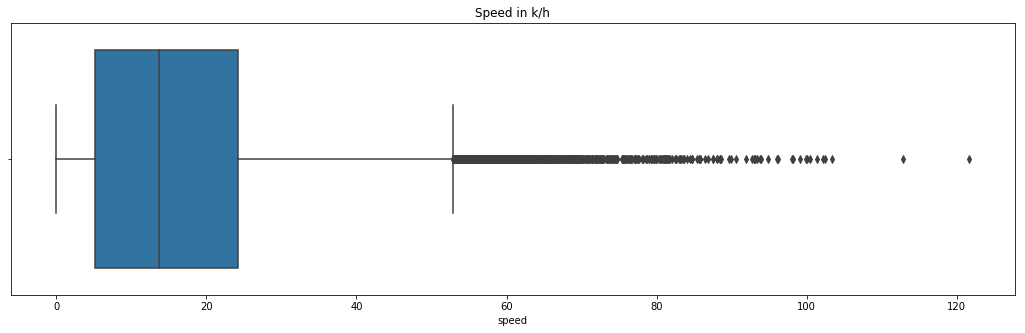

In [18]:
lines = lines.query('speed >= 0')
fig, ax = plt.subplots(figsize=(18,5))
ax.set(title='Speed in k/h')
ax = sns.boxplot(x=lines.speed.apply(lambda x: ms_to_kh(x)))

Ahora tenemos velocidades coherentes y no tenemos outliers que afecten nuestro modelo. Vamos a dejar las velocidades superiores a 15 m/s

In [19]:
large_distances = lines.query('distance > 500')
large_distances.head()

,id,line,longitude,latitude,timestamp,next_longitude,next_latitude,next_timestamp,distance,time,speed
11,76,217,-56.222965,-34.855816,2018-10-02 14:42:38,-56.083332,-34.882233,2018-10-02 16:01:10,13073.155501,01:18:32,2.774439
48,76,217,-56.098970,-34.872250,2018-10-02 16:17:41,-56.106632,-34.870285,2018-10-02 16:19:56,732.347979,00:02:15,5.424800
168,76,217,-56.180183,-34.883415,2018-10-02 16:56:56,-56.187466,-34.880634,2018-10-02 16:59:42,732.776170,00:02:46,4.414314
342,68,217,-56.222830,-34.855732,2018-10-02 15:07:24,-56.083282,-34.882317,2018-10-02 16:25:41,13069.811782,01:18:17,2.782587
579,15,217,-56.223000,-34.855633,2018-10-02 14:39:08,-56.083332,-34.882050,2018-10-02 15:45:55,13076.294595,01:06:47,3.263363


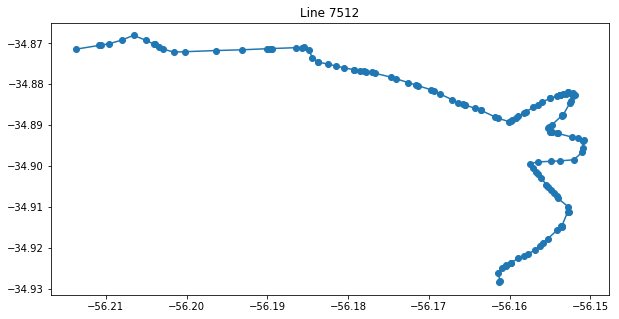

In [20]:
plot_all_line(lines, 7512)

Podemos ver que distancias de 500~600  metros tienen sentido

In [21]:
large_distances = lines.query('distance > 800')
large_distances.head(10)

,id,line,longitude,latitude,timestamp,next_longitude,next_latitude,next_timestamp,distance,time,speed
11,76,217,-56.222965,-34.855816,2018-10-02 14:42:38,-56.083332,-34.882233,2018-10-02 16:01:10,13073.155501,01:18:32,2.774439
342,68,217,-56.222830,-34.855732,2018-10-02 15:07:24,-56.083282,-34.882317,2018-10-02 16:25:41,13069.811782,01:18:17,2.782587
579,15,217,-56.223000,-34.855633,2018-10-02 14:39:08,-56.083332,-34.882050,2018-10-02 15:45:55,13076.294595,01:06:47,3.263363
1433,105,217,-56.222683,-34.855732,2018-10-02 14:51:38,-56.083332,-34.882217,2018-10-02 16:05:40,13049.799294,01:14:02,2.937821
1826,91,217,-56.222850,-34.855717,2018-10-02 15:25:54,-56.083168,-34.881966,2018-10-02 16:47:56,13073.355857,01:22:02,2.656106
1989,91,217,-56.187565,-34.875950,2018-10-02 17:49:13,-56.222850,-34.855750,2018-10-02 18:10:28,3925.362634,00:21:15,3.078716
2249,45,217,-56.222885,-34.855717,2018-10-02 16:01:40,-56.083200,-34.881950,2018-10-02 17:19:42,13073.226769,01:18:02,2.792231
2296,45,217,-56.115784,-34.871130,2018-10-02 17:40:27,-56.135784,-34.871933,2018-10-02 17:49:13,1826.750030,00:08:46,3.472909
2298,45,217,-56.136433,-34.872550,2018-10-02 17:49:43,-56.174118,-34.885017,2018-10-02 18:10:28,3706.626400,00:20:45,2.977210
2676,29,217,-56.179115,-34.883750,2018-10-02 15:41:55,-56.187435,-34.876280,2018-10-02 15:46:10,1125.136303,00:04:15,4.412299


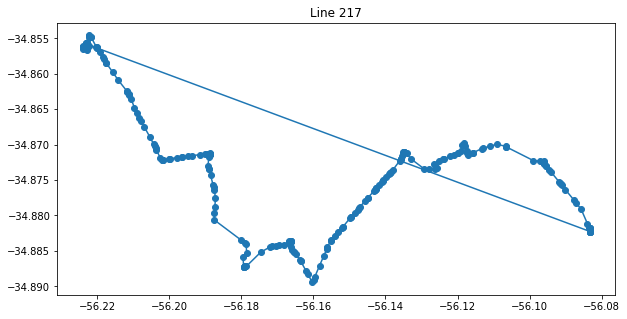

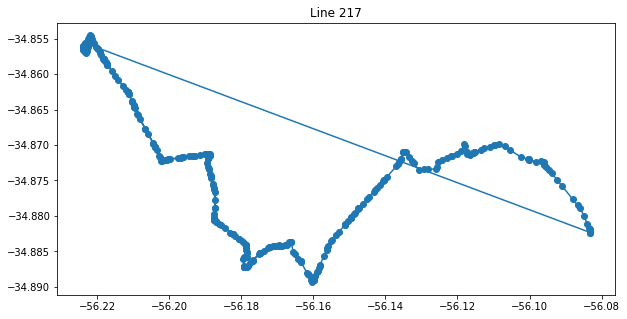

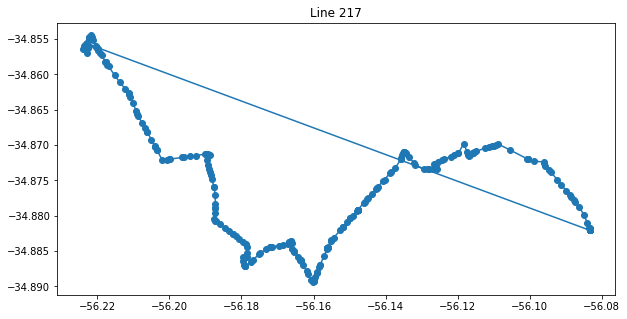

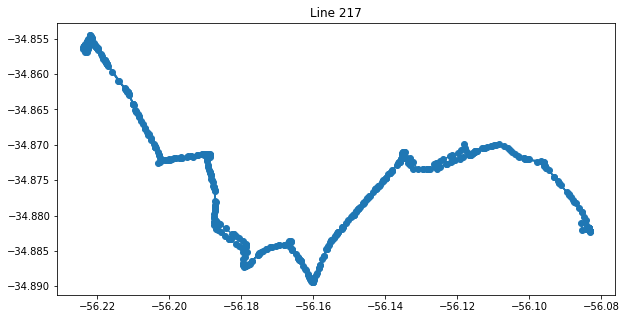

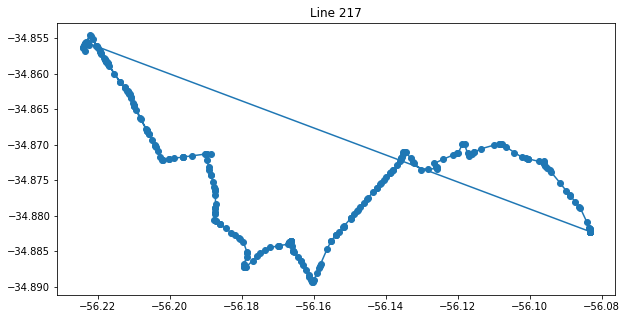

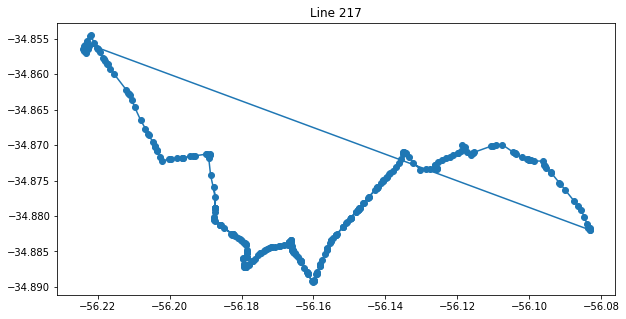

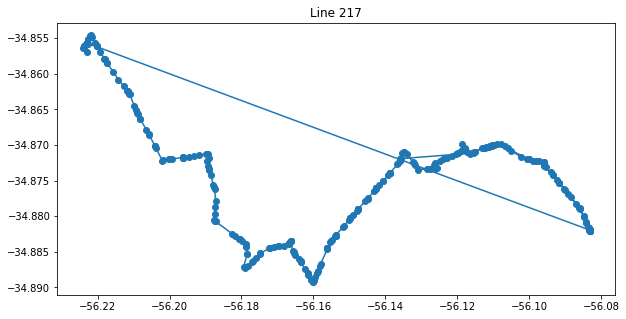

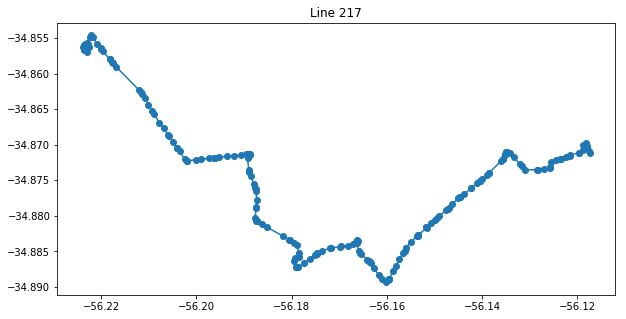

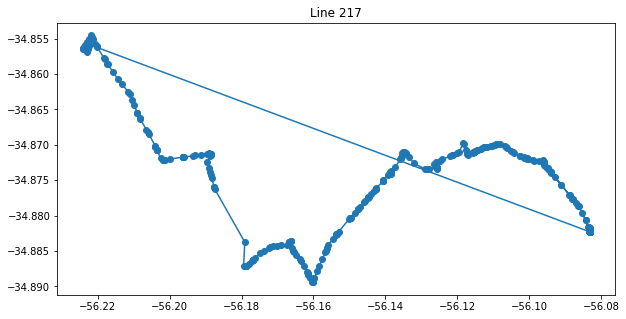

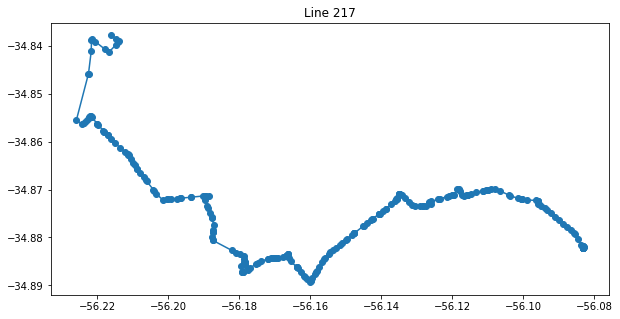

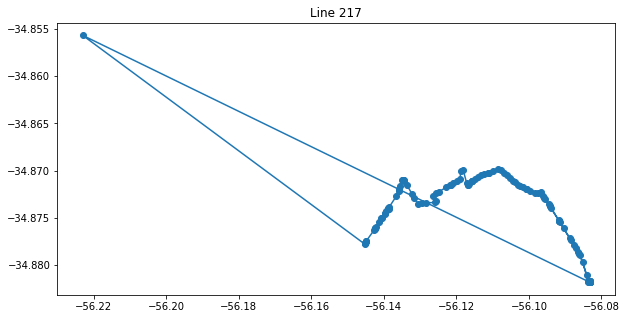

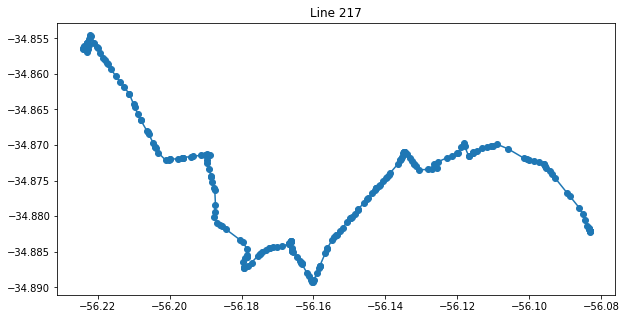

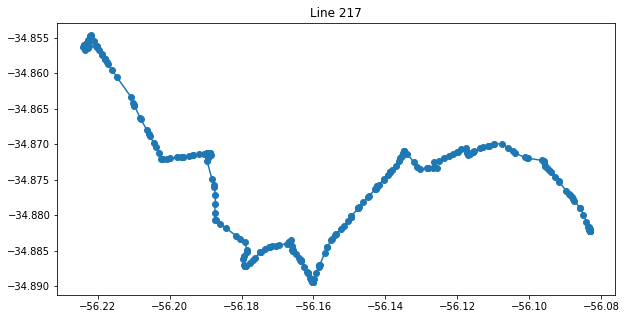

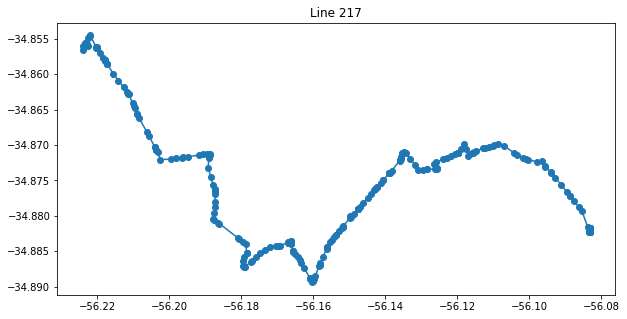

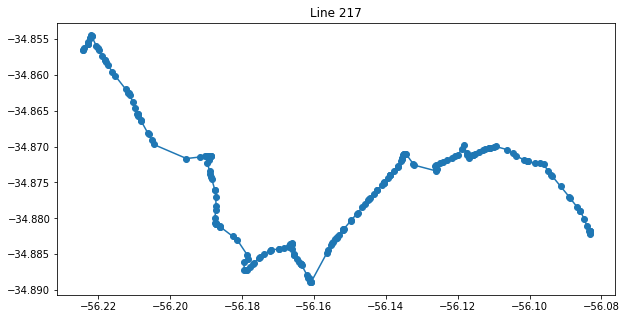

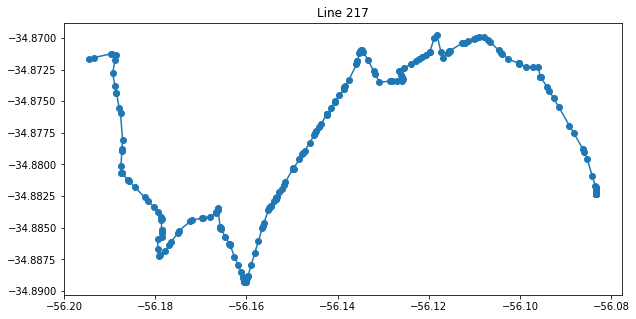

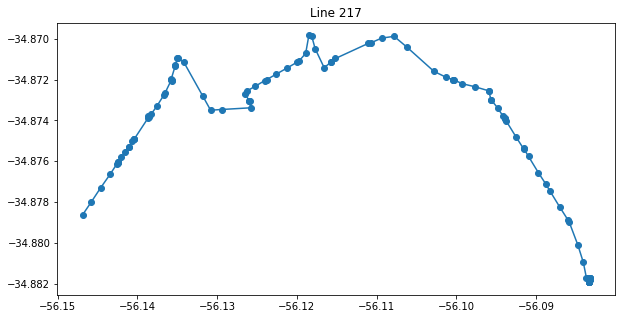

In [22]:
plot_all_line(lines, 217)

Podemos ver que estas distancias superiores a 800 metros suelen ser de nuevos omnibus que salen desde el origien. Esta distancia es obtenida mediante una linea entre el origien y el destino y no nos aporta informacion relevante. Ahora vamos a ver cuantos son estos datos e intentar ver el impacto que tienen al eliminarlos

In [23]:
large_distances.describe()

,id,line,longitude,latitude,next_longitude,next_latitude,distance,time,speed
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398,398.000000
mean,350.957286,3607.959799,-56.152844,-34.878896,-56.153032,-34.877234,7378.167208,0 days 00:52:38.801507,2.955186
std,376.325581,3464.406915,0.047571,0.032527,0.049604,0.033750,4555.901060,0 days 00:35:23.627226,1.920527
min,2.000000,217.000000,-56.253784,-34.928150,-56.254080,-34.928150,821.188877,0 days 00:00:45,0.816688
25%,59.000000,341.250000,-56.197195,-34.905610,-56.197250,-34.904070,3951.545367,0 days 00:21:15,1.908740
50%,121.000000,2389.000000,-56.159695,-34.890274,-56.159333,-34.890055,5847.929401,0 days 00:53:08.500000,2.635522
75%,719.750000,7703.750000,-56.125034,-34.862020,-56.125035,-34.855951,10613.094094,0 days 01:18:32,3.373455
max,1111.000000,7929.000000,-55.995472,-34.768833,-55.996166,-34.715830,22490.074027,0 days 03:31:20,20.042696


In [24]:
lines.count()

id                96004
line              96004
longitude         96004
latitude          96004
timestamp         96004
next_longitude    96004
next_latitude     96004
next_timestamp    96004
distance          96004
time              96004
speed             96004
dtype: int64

Eliminado estos datos con largas distancias estariamos perdiendo 398/96004 datos. Como no son muchos vamos a eliminarlos

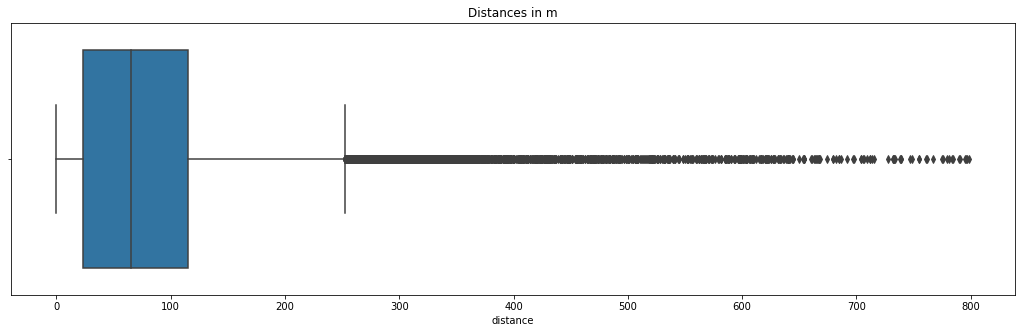

In [25]:
lines = lines.query('distance <= 800')
fig, ax = plt.subplots(figsize=(18,5))
ax.set(title='Distances in m')
ax = sns.boxplot(x=lines.distance)

Observemos algunos de los datos que tenemos hasta ahora

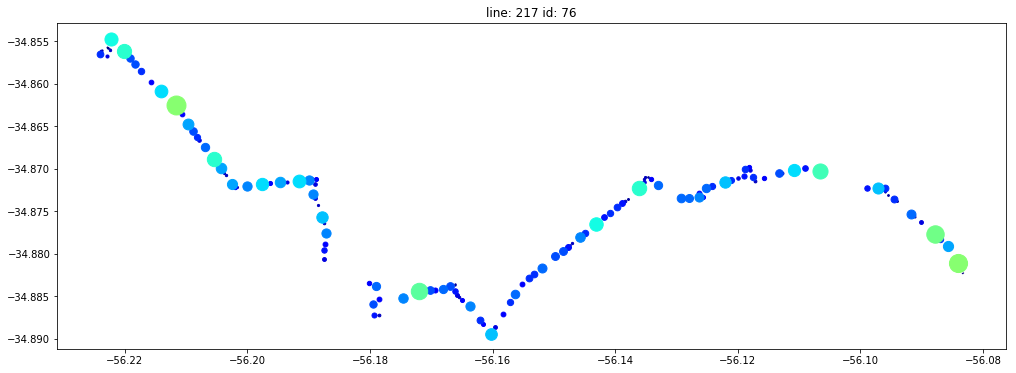

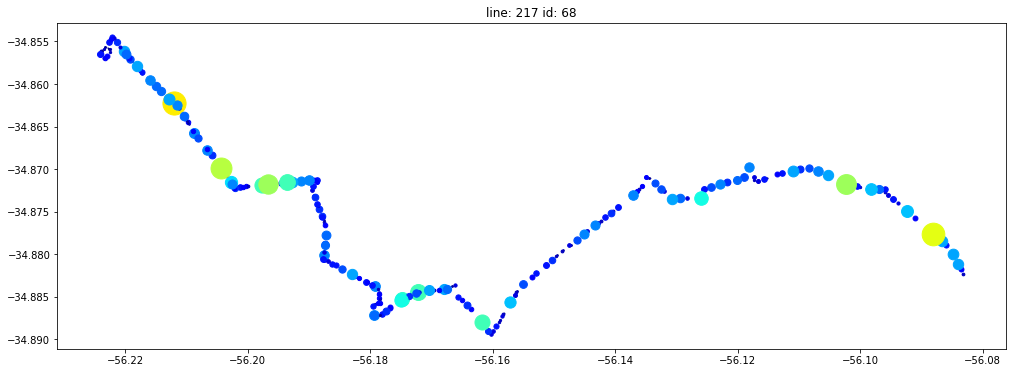

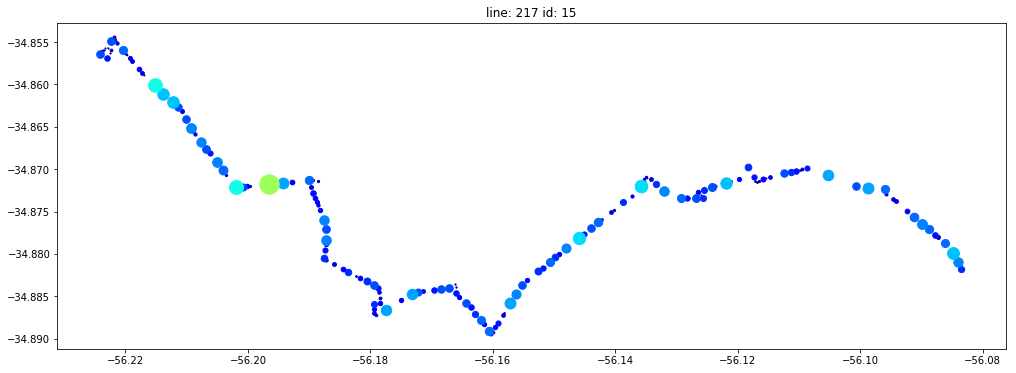

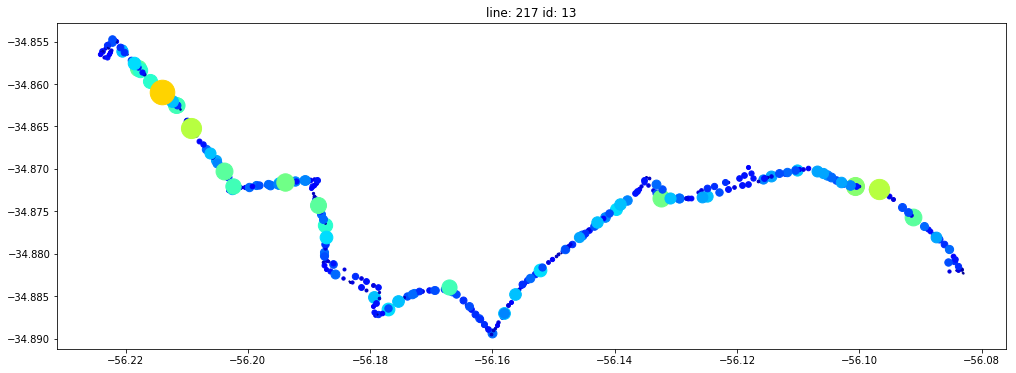

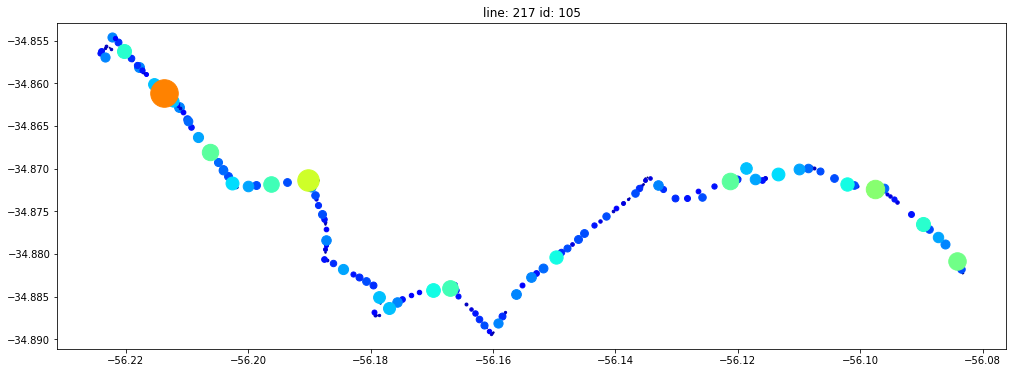

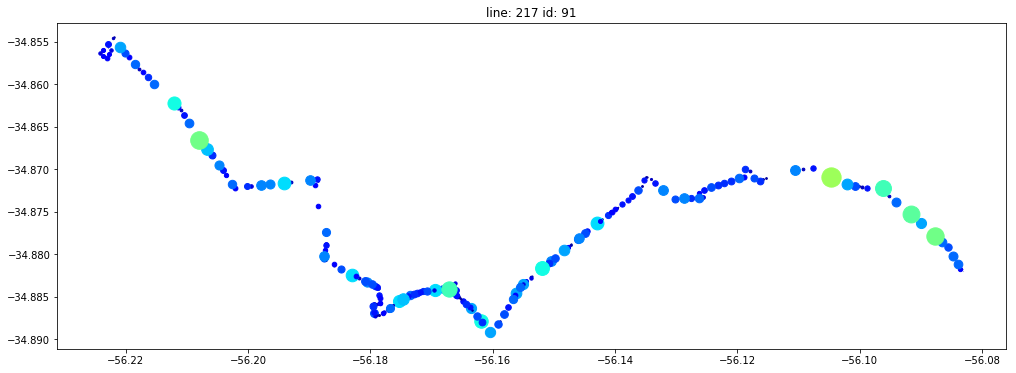

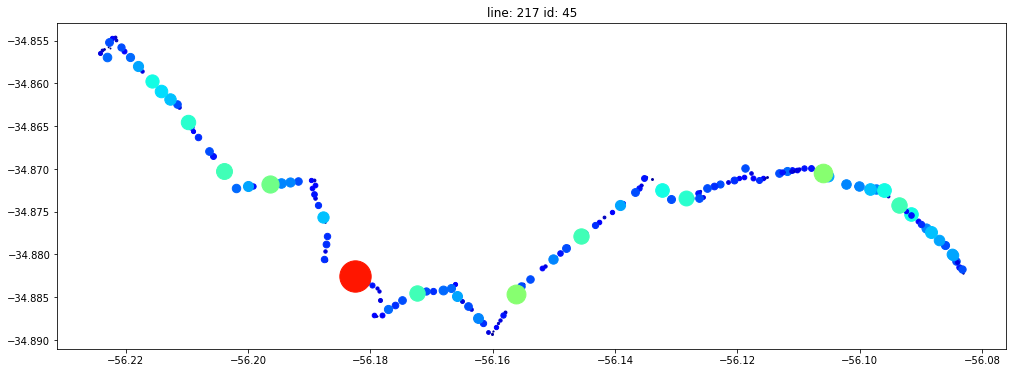

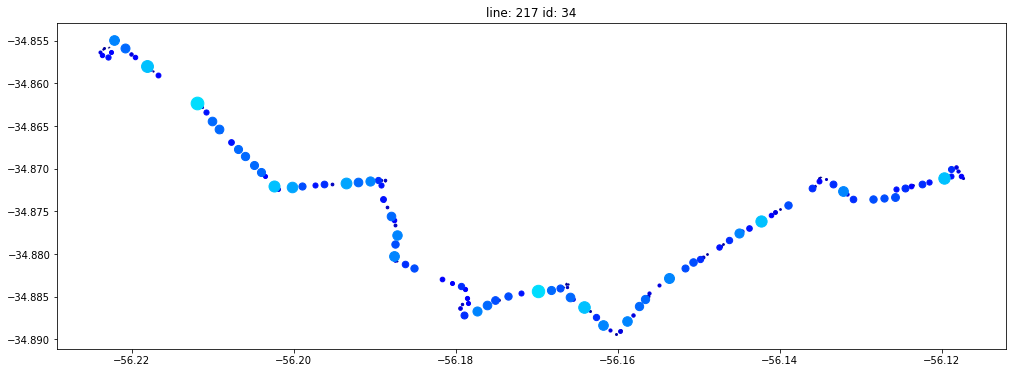

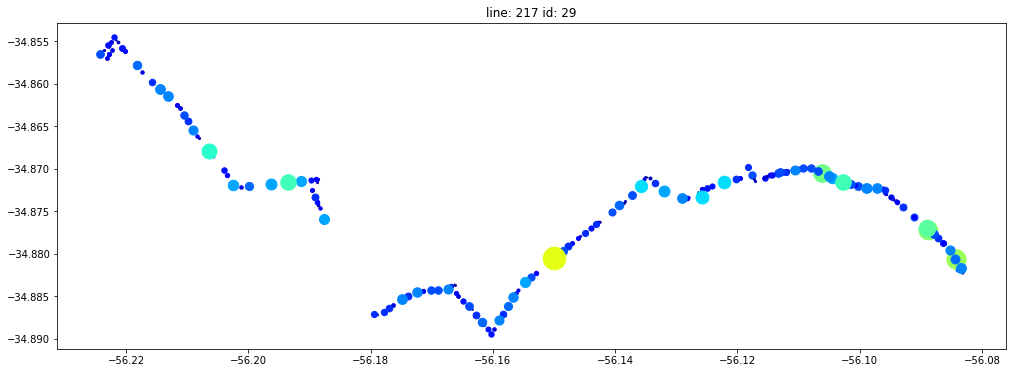

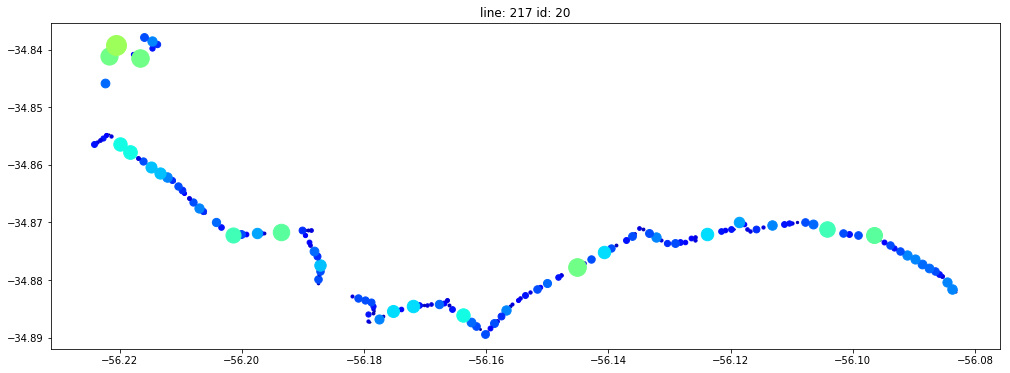

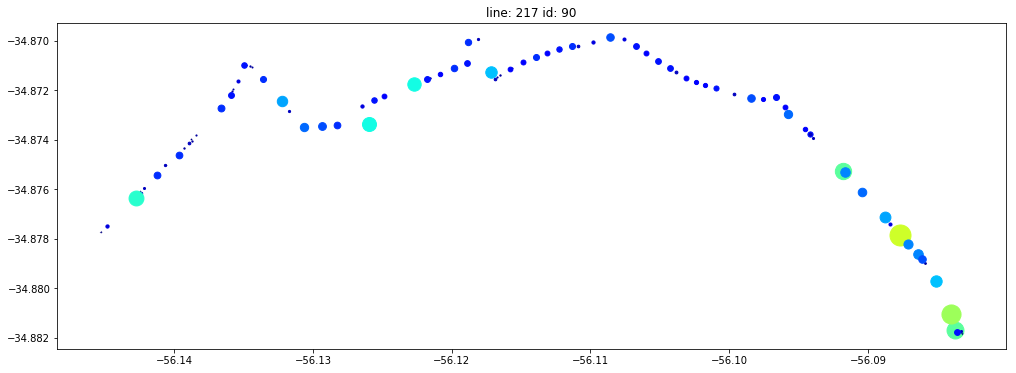

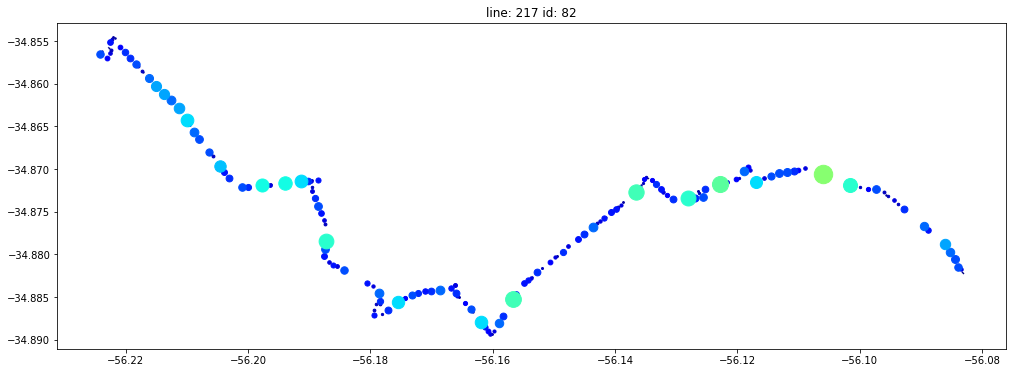

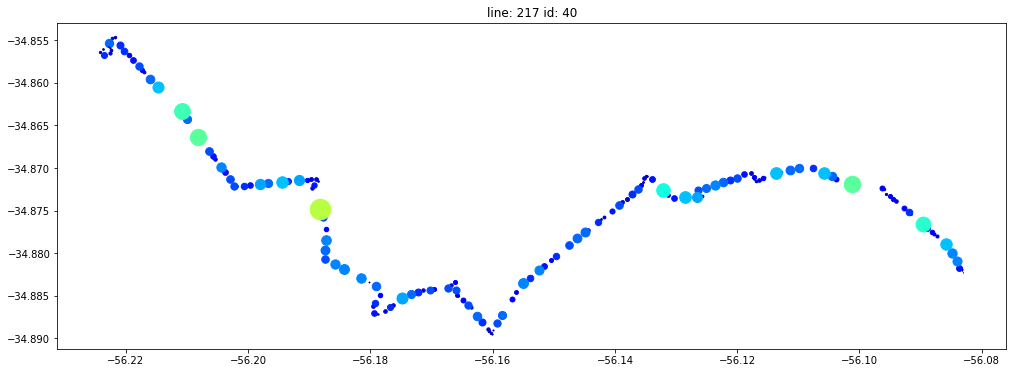

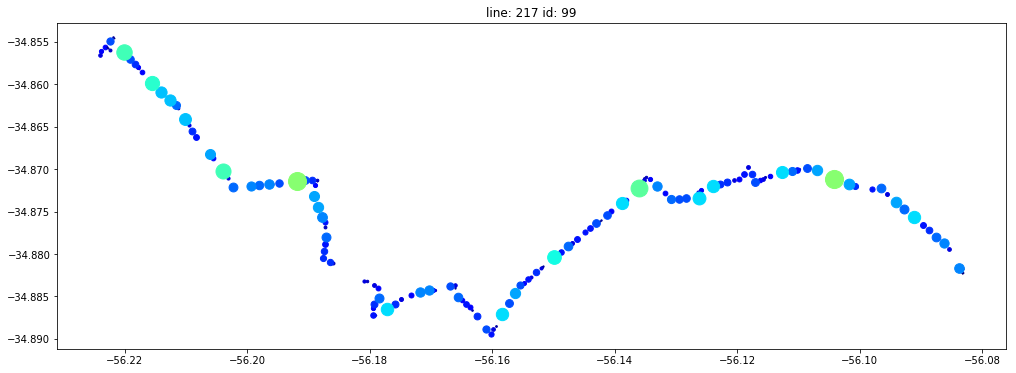

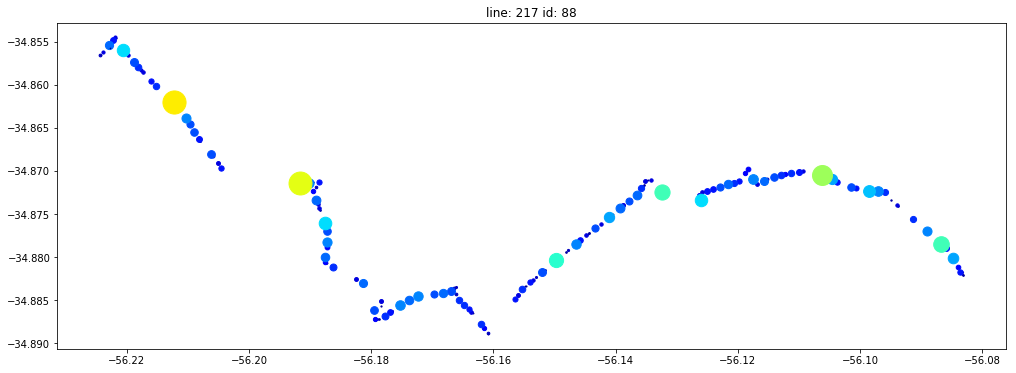

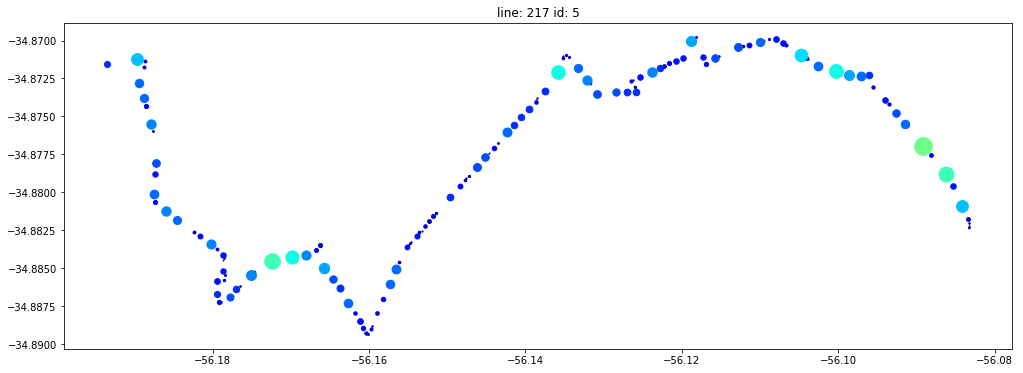

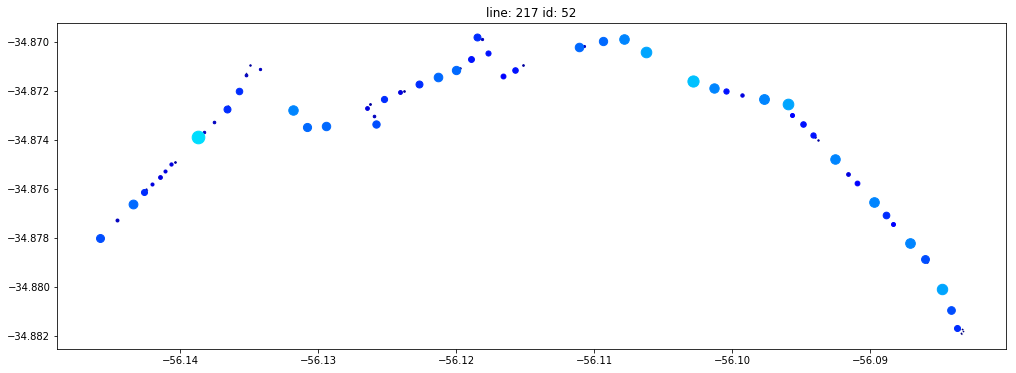

In [26]:
unique_ids = lines[lines.line == 217].id.unique()
for _id in unique_ids:
    line = lines.query('id == {0} & line == 217'.format(_id))
    plot_line_speed(line, False)

In [27]:
lines.to_csv('../data/bus_data_stage_2.csv')

# Resumen 

Partimos de un conjunto de datos obtenidos de un servicio que eschaba mediante _hooks_ una simulacion de omnibus de la intendencia la cual enviaba los siguientes datos:

* **id**
* **type**
* **busCode**
* **line**
* **longitude**
* **latitude**
* **timestamp**

Elimiamos las columnas que no aportaban información relevante y nos quedamos con:

* **id**
* **line**
* **longitude**
* **latitude**
* **timestamp**

Como el problema trata de omnibus dentro de Montevideo definimos una _bounding box_ que contiene a la ciudad de montevideo para ver si alguna de las coordenadas _("longitude", "latitude")_ quedaba fuera. Descubrimos que lineas como 142 llegan a Canelones pero son consideradas lineas urbanas por lo cual no las descartamos.

Vimos que por cada linea tenemos varios omnibus y que en algunos de los recorridos no tenemos informacion del trayecto completo, lo cual podia ser ocacionado por problemas en la simulacion o que algunas lineas y sublineas se referencien con el mismo id.

Para las diferentes coordenadas obtenidas en orden cronologico por omnibus calculamos las distancias (con la formula de Haversine) y el tiempo entre la informacion contigua obtenida. Con estos datos calculamos la velocidad de los omnibus.

Descubrimos que para algunas lineas existen segmentos del trayecto con desvios e introdijimos el archivo `v_uptu_lsv.csv` obtenido de los datos abiertos de la IMM el cual nos permite mapear los identificadores a los nombres utilizados por las lineas de omnibus.

Al calcular los tiempos y distancias para todos los datos vimos que teniamos velocidades negativas y distancias muy largas.

Las velocidades negativas fueron eliminadas y las distancias superiores a 800m tambien se eliminarn ya que eran pocos datos.

En la proxima sección vamos a intentar separar Montevideo y parte de Canelones en diferentes sectores para analizar la  relación entre las velocidades y la ubicación.